<a href="https://colab.research.google.com/github/mrhamedani/Gen-AI-projects-Pytorch/blob/main/4.%20with_without_glasses_CGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# purpose: Selecting Characteristics(with or without glasses) in Generated Images

### 1. Download and prepare the Dataset
The eyeglasses dataset we use is from Kaggle. Log into Kaggle and go to the link https://www.kaggle.com/datasets/jeffheaton/glasses-or-no-glasses/data to download the image folder and the two CSV files on the right

Using the Kaggle API JSON file, I saved the data set directly in the Google Colab temporary memory

In [5]:
from google.colab import files
files.upload()

Saving kaggle (1).json to kaggle (1) (2).json


{'kaggle (1) (2).json': b'{"username":"rezahamedani","key":"d5c4f587c7cea3dc259ab608e99e3a8b"}'}

In [ ]:

!kaggle datasets download -d jeffheaton/glasses-or-no-glasses
!unzip glasses-or-no-glasses.zip

Streaming output truncated to the last 5000 lines.
  inflating: faces-spring-2020/faces-spring-2020/face-1000.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1001.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1002.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1003.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1004.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1005.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1006.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1007.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1008.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1009.png  
  inflating: faces-spring-2020/faces-spring-2020/face-101.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1010.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1011.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1012.png  
  inflating: faces-spring-2020/faces-spr

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import os , shutil
from PIL import Image
import random
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder


In [17]:
train = pd.read_csv('train.csv')
train.set_index('id',inplace=True)
test = pd.read_csv('test.csv')
test.set_index('id',inplace=True)

os.makedirs('./glasses/G/', exist_ok=True)
os.makedirs('./glasses/NoG/',exist_ok=True)

folder= "./faces-spring-2020/faces-spring-2020/"

for i in range(1, 4501):
    oldpath = f"{folder}face-{i}.png"
    if train.loc[i].glasses == 1:
        newpath = f'./glasses/G/face-{i}.png'  # A new way for pictures with glasses
        shutil.copy(oldpath, newpath)
    else:
        newpath = f'./glasses/NoG/face-{i}.png'  #A new path for glasses-free images
        shutil.copy(oldpath, newpath)

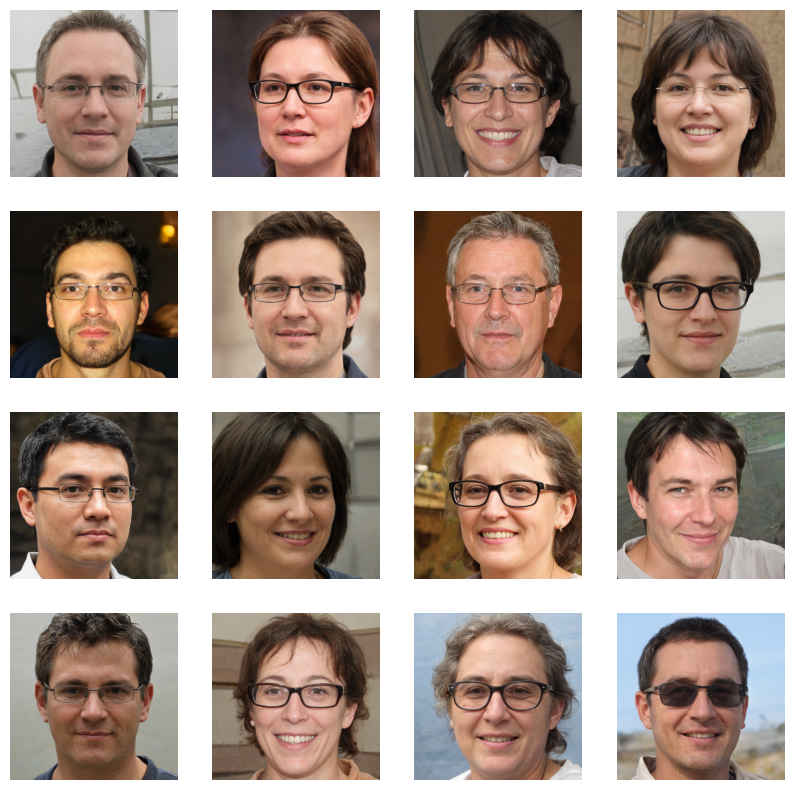

In [6]:
imgs=os.listdir('./glasses/G')
random.seed(42)
samples = random.sample(imgs, 16)
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for i, img in enumerate(samples):
    img_path = os.path
    ax = axs[i // 4, i % 4]
    ax.imshow(Image.open(os.path.join('./glasses/G', img)))
    ax.axis('off')
plt.show()


### 2. Conditional GAN wtih Wasserstein Distance

In [7]:
# determine the device automatically
device = "cuda" if torch.cuda.is_available() else "cpu"
class Critic(nn.Module):
    def __init__(self, img_channels, features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(img_channels, features, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self.block(features, features * 2, 4, 2, 1),
            self.block(features * 2, features * 4, 4, 2, 1),
            self.block(features * 4, features * 8, 4, 2, 1),
            self.block(features * 8, features * 16, 4, 2, 1),
            self.block(features * 16, features * 32, 4, 2, 1),
            nn.Conv2d(features * 32, 1, kernel_size=4,stride=2, padding=0))

    def block(self, in_channels, out_channels,kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels,out_channels,
                kernel_size,stride,padding,bias=False,),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2))

    def forward(self, x):
        return self.net(x)

In [8]:
class Generator(nn.Module):
    def __init__(self, noise_channels, img_channels, features):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            self.block(noise_channels, features *64, 4, 1, 0),
            self.block(features * 64, features * 32, 4, 2, 1),
            self.block(features * 32, features * 16, 4, 2, 1),
            self.block(features * 16, features * 8, 4, 2, 1),
            self.block(features * 8, features * 4, 4, 2, 1),
            self.block(features * 4, features * 2, 4, 2, 1),
            nn.ConvTranspose2d(features * 2, img_channels, kernel_size=4,stride=2, padding=1),
            nn.Tanh())
    def block(self, in_channels, out_channels,
              kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding,bias=False,),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),)
    def forward(self, x):
        return self.net(x)

### 3.  Weight initialization and the gradient penalty function

In [9]:
#We select the initial weights using the normal distribution. This allows us to
#get the right coefficients much faster (instead of choosing randomly).
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [10]:
z_dim=100
img_channels=3
features=16
gen=Generator(z_dim+2,img_channels,features).to(device)
critic=Critic(img_channels+2,features).to(device)
weights_init(gen)
weights_init(critic)

In [11]:
lr = 0.0001
opt_gen = torch.optim.Adam(gen.parameters(),
                         lr = lr, betas=(0.0, 0.9))
opt_critic = torch.optim.Adam(critic.parameters(),
                         lr = lr, betas=(0.0, 0.9))

In [12]:
# This piece of code is related to the penalty gradient and is usually available
#to us in a ready form and it doesn't matter if we know what it does.
def GP(critic, real, fake):
    B, C, H, W = real.shape
    alpha=torch.rand((B,1,1,1)).repeat(1,C,H,W).to(device)
    interpolated_images = real*alpha+fake*(1-alpha)
    critic_scores = critic(interpolated_images)
    gradient = torch.autograd.grad(inputs=interpolated_images,
        outputs=critic_scores,
        grad_outputs=torch.ones_like(critic_scores),
        create_graph=True,
        retain_graph=True)[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gp = torch.mean((gradient_norm - 1) ** 2)
    return gp

### 4. Train the conditional GAN


In [13]:
# Adding labels
batch_size=16
imgsz=256
transform= T.Compose([
    T.Resize((imgsz,imgsz)),T.ToTensor(),T.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
data_set=torchvision.datasets.ImageFolder(root="./glasses",transform=transform)

In [14]:
# glasses label = [1,0]
# no glasses label = [0,1]
#[3,256,256] --> [5,256,256]   onehot encoding:We add two more tensors as labels to RGB, which are three tensors
newdata=[]
for i,(img,label) in enumerate(data_set):
    onehot=torch.zeros((2))
    onehot[label]=1
    channels=torch.zeros((2,imgsz,imgsz))
    if label==0:
        channels[0,:,:]=1
    else:
        channels[1,:,:]=1
    img_and_label=torch.cat([img,channels],dim=0)
    newdata.append((img,label,onehot,img_and_label))

In [15]:
data_loader=torch.utils.data.DataLoader(newdata,batch_size=batch_size,shuffle=True)
newdata[0] # There are four values ​​in this list : [(R - G - B) - label(created by ImageFolder)-label(The label we want to add),(R-G-B-1,0)]

(tensor([[[0.6078, 0.6157, 0.6235,  ..., 0.6157, 0.6157, 0.6157],
          [0.6078, 0.6078, 0.6157,  ..., 0.6157, 0.6078, 0.6000],
          [0.6078, 0.6078, 0.6078,  ..., 0.6078, 0.6078, 0.5922],
          ...,
          [0.5137, 0.5216, 0.5373,  ..., 0.4824, 0.4902, 0.4824],
          [0.5216, 0.5294, 0.5451,  ..., 0.4902, 0.4980, 0.4902],
          [0.5451, 0.5137, 0.5294,  ..., 0.4980, 0.4980, 0.4902]],
 
         [[0.6235, 0.6314, 0.6314,  ..., 0.6235, 0.6392, 0.6314],
          [0.6235, 0.6235, 0.6235,  ..., 0.6157, 0.6157, 0.6235],
          [0.6157, 0.6157, 0.6157,  ..., 0.6078, 0.6157, 0.6078],
          ...,
          [0.5294, 0.5294, 0.5373,  ..., 0.4824, 0.4902, 0.4902],
          [0.5373, 0.5373, 0.5451,  ..., 0.4902, 0.4980, 0.4980],
          [0.5608, 0.5373, 0.5373,  ..., 0.4902, 0.5059, 0.4980]],
 
         [[0.6471, 0.6392, 0.6314,  ..., 0.6314, 0.6471, 0.6627],
          [0.6471, 0.6314, 0.6235,  ..., 0.6078, 0.6235, 0.6471],
          [0.6314, 0.6157, 0.6157,  ...,

In [16]:
def plot_epoch(epoch):
    # test images with glasses
    noise = torch.randn(32, z_dim, 1, 1)
    labels = torch.zeros(32, 2, 1, 1)
    # use label [1,0] so G knows what to generate
    labels[:,0,:,:]=1
    noise_and_labels=torch.cat([noise,labels],dim=1).to(device)
    fake=gen(noise_and_labels).cpu().detach()
    fig=plt.figure(figsize=(20,10),dpi=100)
    for i in range(32):
        ax = plt.subplot(4, 8, i + 1)
        img=(fake.cpu().detach()[i]/2+0.5).permute(1,2,0)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.subplots_adjust(hspace=-0.6)
    plt.savefig(f"sample_data/G{epoch}.png")
    plt.show()
    # test images without glasses
    noise = torch.randn(32, z_dim, 1, 1)
    labels = torch.zeros(32, 2, 1, 1)
    # use label [0,1] so G knows what to generate
    labels[:,1,:,:]=1
    noise_and_labels=torch.cat([noise,labels],dim=1).to(device)
    fake=gen(noise_and_labels).cpu().detach()
    fig=plt.figure(figsize=(20,10),dpi=100)
    for i in range(32):
        ax = plt.subplot(4, 8, i + 1)
        img=(fake.cpu().detach()[i]/2+0.5).permute(1,2,0)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.subplots_adjust(hspace=-0.6)
    plt.savefig(f"sample_data/NoG{epoch}.png")
    plt.show()

In [17]:
def train_batch(onehots,img_and_labels,epoch):
    real = img_and_labels.to(device)
    B = real.shape[0]
    # train critic five times
    for _ in range(5):
        noise = torch.randn(B, z_dim, 1, 1)
        onehots=onehots.reshape(B,2,1,1)
        noise_and_labels=torch.cat([noise,onehots],dim=1).to(device)
        fake_img = gen(noise_and_labels).to(device)
        fakelabels=img_and_labels[:,3:,:,:].to(device)
        fake=torch.cat([fake_img,fakelabels],dim=1).to(device)
        critic_real = critic(real).reshape(-1)
        critic_fake = critic(fake).reshape(-1)
        gp = GP(critic, real, fake)
        loss_critic=(-(torch.mean(critic_real) -
           torch.mean(critic_fake)) + 10 * gp)
        opt_critic.zero_grad()
        loss_critic.backward(retain_graph=True)
        opt_critic.step()
    # train G
    gen_fake = critic(fake).reshape(-1)
    loss_gen = -torch.mean(gen_fake)
    opt_gen.zero_grad()
    loss_gen.backward()
    opt_gen.step()
    return loss_critic, loss_gen

####  Because the implementation of this loop (training) is time-consuming, the prepared file of the training coefficients is available in the link below, and we will not run it again and only use the prepared file.
 https://gitlab.com/amirbig44/pytorch-gan-course/-/blob/main/cgan.pth?ref_type=heads

In [18]:
# for epoch in range(1,101):
#     closs=0
#     gloss=0
#     for _,_,onehots,img_and_labels in data_loader:
#         # train a batch
#         loss_critic, loss_gen = train_batch(onehots,\
#                                 img_and_labels,epoch)
#         closs+=loss_critic.detach()/len(data_loader)
#         gloss+=loss_gen.detach()/len(data_loader)
#     print(f"at epoch {epoch},\
#     critic loss: {closs}, generator loss {gloss}")
#     plot_epoch(epoch)
# torch.save(gen.state_dict(),'./cgan.pth')

<ipython-input-19-0a040e307f33>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("./cgan.pth", map_location=device))


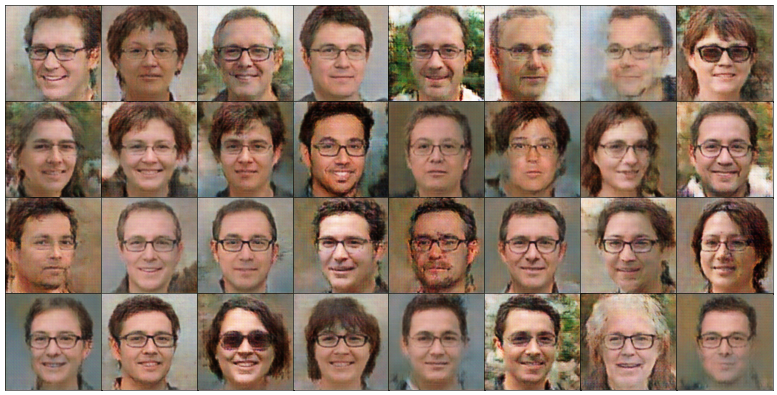

In [19]:
torch.manual_seed(0)

generator=Generator(z_dim+2,img_channels,features).to(device)
generator.load_state_dict(torch.load("./cgan.pth", map_location=device))
generator.eval()

noise_g = torch.randn(32, z_dim, 1, 1)
labels_g = torch.zeros(32, 2, 1, 1)
labels_g[:,0,:,:]=1  # glasses label
#  labels_g[:,1,:,:]=1  # no glasses label
noise_and_labels=torch.cat([noise_g,labels_g],dim=1).to(device)
fake=generator(noise_and_labels)
plt.figure(figsize=(20,10),dpi=50)
for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    img=(fake.cpu().detach()[i]/2+0.5).permute(1,2,0)
    plt.imshow(img.numpy())
    plt.xticks([])
    plt.yticks([])
plt.subplots_adjust(wspace=-0.08,hspace=-0.01)
plt.show()